# regression-04

## What's new:

1-




In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks

2025-10-17 20:38:17.065673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760720897.079763   19429 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760720897.084546   19429 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 1- Load and Scaling Features

df = pd.read_csv('XAGUSD-197001010000--H1-rates.csv', sep='\t')
# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# ensure strings and strip any weird whitespace
df['DATE'] = df['DATE'].astype(str).str.strip()
df['TIME'] = df['TIME'].astype(str).str.strip()

df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], dayfirst=False, errors='coerce')
if df['DATETIME'].isna().any():
    raise ValueError("Some DATETIME values could not be parsed. Check date/time formats.")

# set DATETIME as index for reindexing
df = df.set_index('DATETIME').sort_index()

# --------------------------
# Create continuous hourly index & fill weekend gaps
# --------------------------
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# Reindex to full hourly range so weekends/missing hours appear as NaN rows
df = df.reindex(full_index)

# Columns expected in your CSV
num_cols = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL', 'VOL', 'SPREAD']
for c in num_cols:
    if c not in df.columns:
        raise KeyError(f"Expected column '{c}' not found in dataframe.")

# Fill strategy:
# - Prices: forward-fill last known price across weekend gap (common approach for modeling continuity).
# - TICKVOL / VOL: set missing to 0 (no ticks during weekend).
# - SPREAD: forward-fill last known.
# Alternative: you could leave NaNs and drop sequences that cross weekends (safer but reduces data).
df[['OPEN','HIGH','LOW','CLOSE']] = df[['OPEN','HIGH','LOW','CLOSE']].ffill()
df['SPREAD'] = df['SPREAD'].ffill()
df['TICKVOL'] = df['TICKVOL'].fillna(0)
df['VOL'] = df['VOL'].fillna(0)

# If you want to mark weekend-filled rows, you could add a flag column:
df['WEEKEND_FILLED'] = df['CLOSE'].isna().astype(int)  # before ffill this flagged NaNs; after ffill it would be 0
# But we've already filled, so instead do:
# df['WEEKEND_FILLED'] = df.index.to_series().dt.weekday.isin([5,6]).astype(int)

# Reset index to make DATETIME a regular column again
df = df.reset_index().rename(columns={'index': 'DATETIME'})


In [3]:
# Specify how many rows to remove for model
nn = 1000   # Delete the first nn rows that do not follow the one-hour timeframe.
mm = 500   # Remove mm last row that the model should not see.

# Delete first nn and last mm rows
df_model = df.iloc[nn:len(df)-mm].reset_index(drop=True)


In [4]:
# Select features to scale
features = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']

# Apply MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_model[features])

close_scaler = MinMaxScaler()
scaled_close = close_scaler.fit_transform(df_model[['CLOSE']])


In [5]:
# --- Parameters ---

WINDOW_SIZE = 60
FORECAST_HORIZON = 10

In [ ]:
# Prepare sequences
def create_sequences(features_arr, target_arr, window, horizon):
    X, y = [], []
    # features_arr: (N, n_features), target_arr: (N, 1)
    for i in range(window, len(features_arr) - horizon + 1):
        X.append(features_arr[i - window:i])         # shape (window, n_features)
        y.append(target_arr[i:i + horizon].reshape(horizon))  # shape (horizon,)
    return np.array(X), np.array(y)  # X: (samples, window, n_features), y: (samples, horizon)

X, y = create_sequences(scaled, scaled_close, WINDOW_SIZE, FORECAST_HORIZON)


# Check shapes
print("X.shape:", X.shape)  # expected (samples, 60, 5)
print("y.shape:", y.shape)  # expected (samples, 10)


# Train/test split (time series: no shuffle)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


# --------------------------
# Build LSTM model (output matches y shape)
# --------------------------
model = Sequential([
    LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(FORECAST_HORIZON)   # outputs (batch_size, horizon)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


# Train
mc = callbacks.ModelCheckpoint(filepath='mcp_saved_model.keras', monitor='val_loss', save_best_only=True)
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    verbose=1,
    callbacks=[mc, es],
    validation_split=0.2,
)

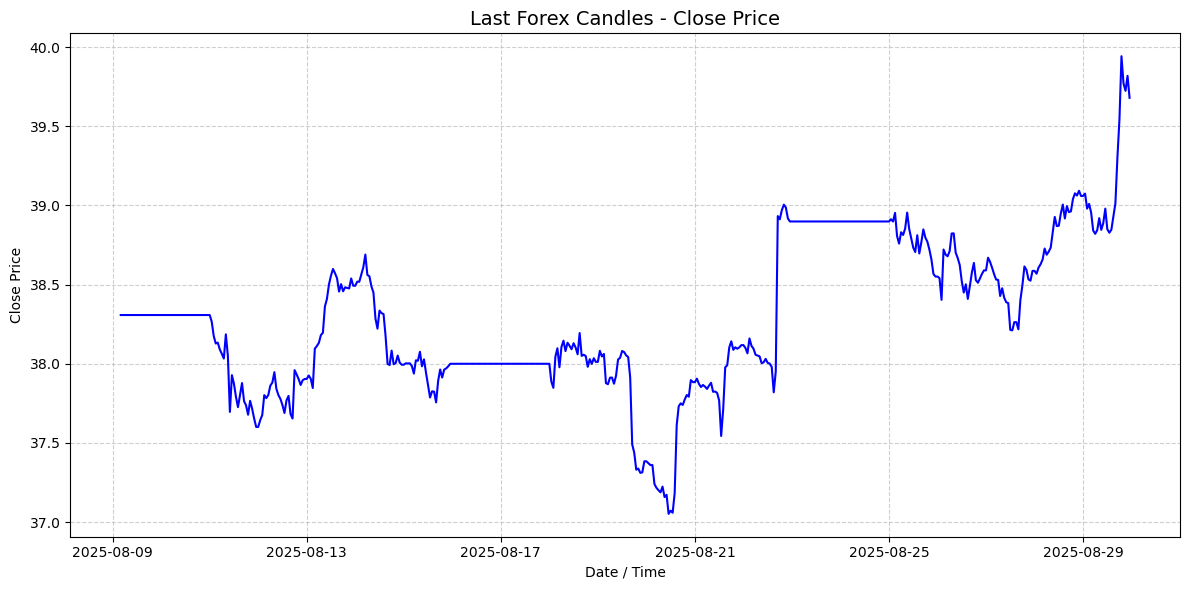

In [7]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# === Parameters ===
xx = 500  # number of last candles to show

# === Select last n rows ===
df_tail = df.tail(xx)

# === Plot Close Price ===
plt.figure(figsize=(12, 6))
plt.plot(df_tail['DATETIME'], df_tail['CLOSE'], color='blue', linewidth=1.5)
plt.title(f'Last Forex Candles - Close Price', fontsize=14)
plt.xlabel('Date / Time')
plt.ylabel('Close Price')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [8]:
# === Load and clean the last 60 rows from a separate CSV file for prediction ===
# --------------------------
# === Prediction block ===
# --------------------------
# Given_time should match format similar to the DATETIME column.
# Example: "2025.08.13 04:00:00"  (note: use a space, not a tab, for clarity)
given_time = "2025.07.31 10:00:00"
given_dt = pd.to_datetime(given_time, errors='coerce')
if pd.isna(given_dt):
    raise ValueError("given_time could not be parsed. Use format 'YYYY.MM.DD HH:MM:SS' or similar.")

# find the starting index in the reindexed df (not df_model)
# We used df reset earlier; find the row in df (not df_model) that matches given_dt.
# If you want to use df_model (i.e. after trimming nn/mm), map given_dt to df_model index:
df_full = df.copy()  # this is the reindexed, reset dataframe with full range
# find row in df_full
matches = df_full.index[df_full['DATETIME'] == given_dt].tolist()
if not matches:
    raise ValueError(f"{given_dt} not found in the dataset index after reindexing. Choose another time within range.")
start_idx_full = matches[0]

# If you want the window to be located inside df_model (i.e., after trimming nn rows),
# compute its index in df_model:
start_idx_in_df_model = start_idx_full - nn
if start_idx_in_df_model < 0 or (start_idx_in_df_model + WINDOW_SIZE) > len(df_model):
    raise ValueError("Requested start time is outside the usable df_model window (after applying nn/mm).")

# Extract previous WINDOW_SIZE rows starting at start_idx_in_df_model (so it is the historical window)
input_df = df_model.iloc[start_idx_in_df_model : start_idx_in_df_model + WINDOW_SIZE].copy()
if input_df.shape[0] != WINDOW_SIZE:
    raise RuntimeError("input_df does not contain WINDOW_SIZE rows - check start index and dataset bounds.")

# scale input features with the same scaler used for training
input_scaled = scaler.transform(input_df[features])  # shape: (WINDOW_SIZE, n_features)
input_sequence = np.expand_dims(input_scaled, axis=0)  # shape: (1, WINDOW_SIZE, n_features)

# Predict
pred = model.predict(input_sequence)  # shape (1, horizon)
pred = pred.reshape(-1, 1)            # shape (horizon, 1) for inverse transform
prediction_close = close_scaler.inverse_transform(pred).flatten()  # final predicted CLOSE prices

print("Predicted CLOSEs (next {} candles):".format(FORECAST_HORIZON))
print(prediction_close)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Predicted CLOSEs (next 10 candles):
[37.003765 37.06118  37.049408 37.06739  37.108463 37.094154 37.078712
 37.035152 37.135265 37.102043]


I0000 00:00:1760720988.929953   19534 cuda_dnn.cc:529] Loaded cuDNN version 91301


# plot section

In [9]:
# --- 2. Extract last 4 candles from input_df ---
historical_df = input_df.tail(4).copy()

# --- 3. Extract next 10 candles immediately after input_df ---
actual_future_df = df.iloc[start_idx_full + WINDOW_SIZE - 1 : start_idx_full + WINDOW_SIZE + FORECAST_HORIZON].copy()


plot_title = 'Actual vs Predicted Forex Closing Prices'
output_plot_path = None  # e.g., 'output.png'

# LOAD DATA FROM PREDICTION

last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=len(prediction_close), freq='h')

# Create DataFrame
predicted_df = pd.DataFrame({'DATETIME': datetime_index, 'CLOSE': prediction_close})

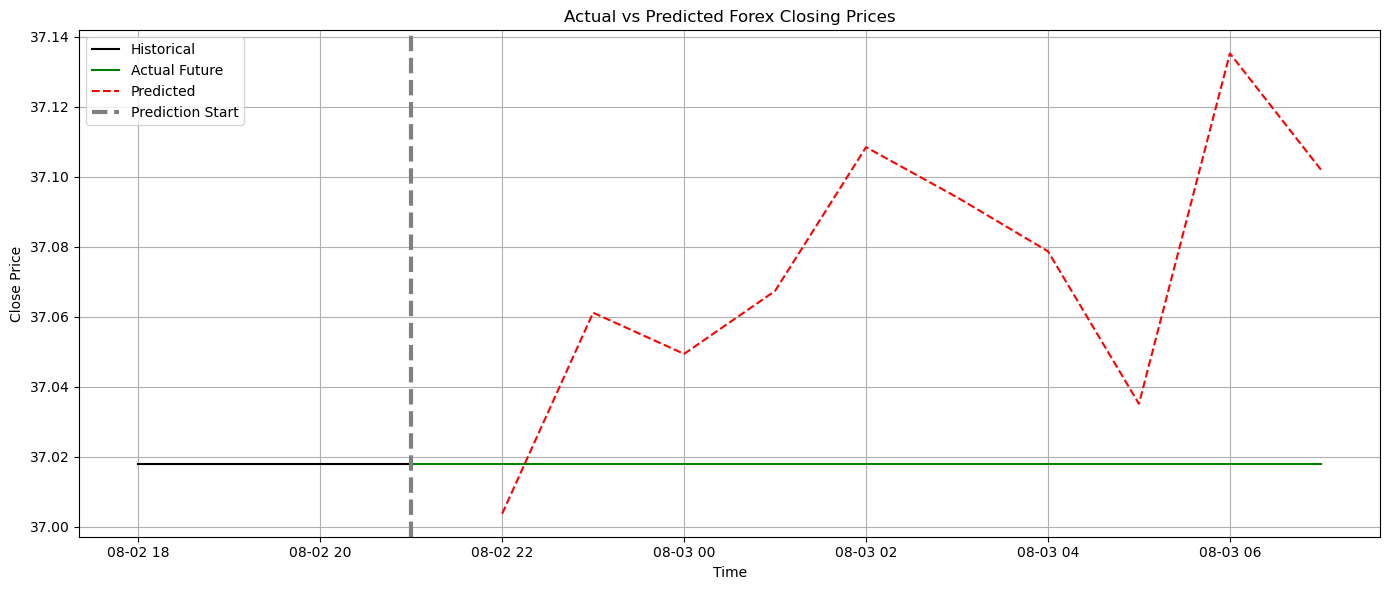

In [10]:
import sys
sys.path.insert(1, '../utils')
import forex_plot_utils_2

# PLOT
forex_plot_utils_2.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)

In [ ]:
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Create timestamp and paths ===
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# === Save model ===
model.save(model_path)

# === Save training history ===
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# === Save training loss plot ===
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# === Save model summary and final performance ===
with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss, final_test_mae = model.evaluate(X_test, y_test, verbose=0)
    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss: {final_test_loss:.6f}\n')
    f.write(f'Final Test MAE : {final_test_mae:.6f}\n')


In [6]:
# Load the trained model
from tensorflow import keras
model = keras.models.load_model('saved_models/model_20251017_200104.keras')

I0000 00:00:1760720922.041466   19429 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2381 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5
